# Prozessierungsschnittstelle (Sentinel-1 SAR)

**Autor*in:** Julian Hausmann
**Copyright:** © 2025 Urbetho CF GmbH
**Lizenz:** Dieses Notebook steht unter der [CC BY-NC-SA 4.0 License](https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en).

<div style="text-align: right"><i> Fortgeschritten </i></div>

In diesem Notebook stellen wir über einen Keycloak-Token und mithilfe der requests Bibliothek un dem OData-Protokoll Zugang zum Cloud-Prozessierungsbereich sowie dem CODE-DE Datenarchiv her. Wir verwenden das [Sentinel-1 Level-1 GRD](https://code-de.org/de/portfolio/?q=Processors-%26-Tools&id=a6ad45fb-d462-410b-87f3-208cfc9cf8b1) Produkt. Es besteht aus fokussierten Synthetic Aperture Radar (SAR)-Daten, die mit Hilfe eines Erdellipsoid-Modells auf den Bodenbereich projiziert wurden. Die Daten werden in einem Cloud-Prozessor aufgerufen, um geländekorrigierte Rückstreuungsdaten zu berechnen. Diese werden dann visualisiert, um verschiedene Landnutzungen visuell zu identifizieren. 

CODE-DE stellt verschiedene Cloud-Prozessoren über seine Prozessierungsschnittstelle (On-Demand Processing API) zur Verfügung. Neben Sentinel-1 Daten können auch Sentinel-2 und Sentinel-3 Daten weiterverarbeitet werden. Die Prozessoren akzeptieren zusätzliche Parameter und bieten Outputdateien an, die nicht durch die fertigen Produkte im Datenkatalog abgedeckt werden. Der Prozess kann durch die unten beschreibene OData API aufgerufen werden oder im [Workspace](https://explore.code-de.org/workspace/processing-center) des CODE-DE Data Explorer über eine graphische Benutzeroberfläche verwendet werden.   

**General Note 1**: Ausführung der Zellen durch pressen des <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button vom top MENU (oder `Shift` + `Enter`).

**General Note 2**: Falls der Kern nich mehr arbeitet, im the top MENU, klicke <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Dann, im top MENU, clicke  "Run" aund wähle "Run All Above Selected Cell".

**General Note 3**: Schauen Sie sich im [**FORUM**](https://forum.code-de.org/de/) um oder Kontaktieren Sie den Support! 

<img src="https://s3.waw3-1.cloudferro.com/swift/v1/frontend-new-portal-code-de/media/filer_public/a3/a8/a3a8f3fc-d9a7-4a22-8aed-c353485293cf/processor_s1_l2_card-bs.jpeg">

*Die Abbildung zeigt eine beispielhafte Szene, die mit dem card_bs Prozessor aus Sentinel-1 Level-1 GRD Daten berechnet wurde. Die verschiedenen Farben deuten auf unterschiedliche Eigenschaften der Oberfläche hin. Das Bild stammt aus dem Portfolio von [CODE-DE](https://code-de.org/de/portfolio/?q=Processors-%26-Tools&id=a6ad45fb-d462-410b-87f3-208cfc9cf8b1).*

#### 1. Installieren der benötigter Bibliotheken

Verschiedene Pakete müssen installiert werden, bevor Download und Analyse der Daten gestartet werden können. Die Liste der zu installierenden Bibliotheken ist abhängig von den bereits lokal installierten Bibliotheken und muss dementsprechend erweitert werden, falls Bedarf besteht.

In [1]:
!pip install numpy rasterio matplotlib geopandas pyproj tqdm

Defaulting to user installation because normal site-packages is not writeable


#### 2. Importieren der benötigten Bibliotheken

In [2]:
# Versuch die benötigten Pakete zu installieren
try:
    # Liste aller benötigter Pakete
    import numpy, rasterio, matplotlib, geopandas, pyproj, requests, json, time, os, zipfile, getpass, glob, math, re
    from geopy.geocoders import Nominatim
    from IPython.display import clear_output
    import matplotlib.pyplot as plt
    import numpy as np
    from rasterio.windows import Window
    from rasterio.windows import from_bounds
    from pyproj import Transformer
    from tqdm import tqdm
    
    # Text Ausgabe
    print("Erfolgreicher Import der benötigten Bibliotheken.")
    
except:
    # Text Ausgabe
    print("Nicht erfolgreicher Import der benötigten Bibliotheken.")

Erfolgreicher Import der benötigten Bibliotheken.


#### 3. Erstellen des Keycloak-Token

Für das Prozessieren und Herunterladen von CODE-DE Datensätzen benötigen Sie ein Autorisierungs-Token (Keycloak-Token), da nur autorisierte Benutzer Erdbeobachtungsdatenprodukte herunterladen dürfen. Sie werden ein autorisierter Benutzer, wenn sie sich auf https://code-de.org anmelden. In diesem Abschnitt generieren wir diesen Token und weisen ihn der Variable access_token zu, die dann im folgenden Skript mehrfach verwendet wird. Bitte geben Sie ihren eigenen Benutzernamen und das korrespondierende Passwort ein.

Mehr Informationen zum Erstellen des Keycloak-Token erhalten Sie in der CODE-DE [**Knowledge Base**](https://knowledgebase.code-de.org/en/latest/eodata/Using-curl-and-wget-to-download-EODATA-products-from-CODE-DE.html).

In [3]:
# Authentifizierungsparameter
client_id = "catalog-public"
grant_type = "password"
url = "https://auth.fra1-1.cloudferro.com/auth/realms/code-de/protocol/openid-connect/token"

# Benutzer zur Eingabe der Anmeldedaten auffordern
username = input('Benutzername: ')
password = getpass.getpass('Passwort: ')

# Anforderungsheader (benötigt für das Absenden von Formulardaten)
headers = {
    "Content-Type": "application/x-www-form-urlencoded",
}

# Nutzdaten für die Authentifizierungsanforderung
data = {
    "grant_type": grant_type,
    "username": username,
    "password": password,
    "client_id": client_id
}

try:
    # Sende die POST-Anforderung an den Authentifizierungs-Endpunkt
    response = requests.post(url, data=data)

    # Überprüfen, ob die Authentifizierungsanforderung erfolgreich war
    if response.status_code == 200:

        # JSON-Antwort parsen, um das Zugriffstoken zu extrahieren
        token_data = response.json()
        access_token = token_data.get("access_token")

        # Erfolgsnachricht, wenn das Token empfangen wurde
        if access_token:
            print("Zugriffstoken empfangen.")

        # Fehlermeldung, wenn das Token nicht empfangen wurde
        else:
            print("Zugriffstoken nicht in der Antwort gefunden.")

    # Fehlermeldung für eine nicht erfolgreiche Anfrage
    else:
        print(f"Fehler beim Abrufen des Tokens. Status-Code: {response.status_code}")
        print(response.text)

# Fehlerbehandlung für alle Ausnahmen, die während der Anfrage auftreten
except Exception as e:
    print(f"Es ist ein Fehler aufgetreten: {e}")

Benutzername: julian.hausmann@uni-bonn.de
Passwort: ········
Zugriffstoken empfangen.


#### 4. Erstellen einer API-URL mithilfe des OData-Protokoll

Nun möchten wir eine Sentinel-1 Level-1 Szene aussuchen. Die OData API erlaubt verschiedene Parameter, um die Suche im CODE-DE Katalog einzugrenzen. Die Anfrage über die API-URL basiert auf dem OData-Protokoll. Es ist eine standardisierte Möglichkeit, um auf Daten über HTTP zuzugreifen, sie zu filtern und zu manipulieren. Es wird häufig verwendet, um auf geospatiale und andere komplexe Datensätze zuzugreifen, wie im Fall von CODE-DE, einer Plattform für Geodaten.

Mehr Informationen dazu, wie mit dem OData-Protokoll gearbeitet werden kann, um auf CODE-DE auf Daten zu zugreifen wird in der [Knowledge Base](https://knowledgebase.code-de.org/en/latest/eodata/Using-curl-and-wget-to-download-EODATA-products-from-CODE-DE.html) erklärt. Dort wird auch auf ein anderes Protokoll, das OpenSearch-Protokoll eingegangen, dass ebenfalls verwendet werden kann, um auf CODE-DE Daten zuzugreifen.

Wir entscheiden uns in diesem Skript dafür nur Szenen aus dem August 2024 zu verwenden. Als Produkttyp geben wir "GRD" an, was für Ground Range Detected steht, also SAR-Daten, die mit Hilfe eines Erdellipsoid-Modells auf den Bodenbereich projiziert wurden. Diese Ausgangsprozessierung ist notwendig, um später die Cloud-Prozessierung durchzuführen. 

Bevor die API-URL erstellt wird, wird geprüft, ob für den gesuchten Ort Koordinaten gefunden werden können. Dafür wird die `nominatim` Bibliothek verwendet. Sie nutzt einen Geolocator, der als Enigabe Parameter Namen von Städten akzeptiert. 

Mehr Informationen darüber wie die `nominatim` Bibliothek verwendet werden kann, finden sie [hier](https://nominatim.org/release-docs/develop/api/Search/).

Anschließend wird geprüft, ob die API-URL erfolgreich war und Ergebnisse hervorbringt. 

In [45]:
# Erstellen eines Geolocators mit einem benutzerdefinierten User-Agent
geolocator = Nominatim(user_agent="geoapi")

# Eingabe des Ortsnamen
place = input("Bitte gibt einen zu untersuchenden Ort ein: ")

# Geocoding: Umwandlung des Ortsnamens in geografische Koordinaten
location = geolocator.geocode(place)
year = "2024"
month = "08"
productType = "GRD"

# Überprüfen, ob der Ort gefunden wurde
if location:
    # Extrahieren der Breiten- und Längengrade
    lat = location.latitude
    lon = location.longitude
    
else:
    # Fehlermeldung, falls der Ort nicht gefunden wurde
    print("Der angegebene Ort konnte nicht gefunden werden.")
    
# API-URL für die Anfrage
api_url = f"https://datahub.code-de.org/odata/v1/Products?$filter=Collection/Name eq 'SENTINEL-1' and OData.CSC.intersects(area=geography'SRID=4326;POINT({lon} {lat})') and ContentDate/Start gt {year}-{month}-01T00:00:00.000Z and ContentDate/Start lt 2025-01-01T00:00:00.000Z and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq '{productType}') and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'operationalMode' and att/OData.CSC.StringAttribute/Value eq 'IW')&$top=1&$orderby=ContentDate/Start asc"

# Sende die GET-Anfrage an die API, um eine Liste von Sentinel-1 Level-1 GRD Szenen zu erhalten
response = requests.get(api_url)

# Überprüfe, ob die Anfrage erfolgreich war (Statuscode 200)
if response.status_code == 200:
    
    # Zerlegen der JSON Antwort
    data = response.json()
    print("Die Anfrage wurde erfolgreich gesendet.")

# Drucke Fehlermeldung, wenn die Anfrage nicht erfolgreich war
else:
    print(f"Antwortfehler. Error Code: {response.status_code}")
    print(f"Antwortinhalt:", response.text)

Bitte gibt einen zu untersuchenden Ort ein: Wismar
Die Anfrage wurde erfolgreich gesendet.


Wenn die API-URL erfolgreich gesendet werden konnte, beinhaltet die Antwort eine Liste von Sentinel-1 Level-1 GRD Szenen. Da wir uns nur für eine Szene interessieren, wird die nur die erste Szene verwendet und ihr Name gespeichert. 

In [5]:
# Definieren der Sentinel-1 Szene
s1_scene = data["value"][0]["Name"]

# Ausgabe
print("Die folgende Sentinel-1 Szene steht zur Verfügung:")
print(s1_scene)

Die folgende Sentinel-1 Szene steht zur Verfügung:
S1A_IW_GRDH_1SDV_20240801T052526_20240801T052551_055015_06B3CE_77FE.SAFE


#### 5. Abfragen der Prozessoren

In diesem Schritt möchten wir zunächst herausfinden, welche Workflows es für Sentinel-1 Level-1 GRD Daten gibt. Dafür verwenden wir die folgende API-URL:

https://datahub.code-de.org/odata/v1/Workflows

Außerdem ergänzen wir in unsere Anfrage bei den Parametern den Produkttyp.

Als Ergebnis lassen wir uns sowohl den DisplayName und den WorkflowName des Workflows ausgeben, damit wir ihn dann im nächsten Schritt in der Prozessierungsschnittstelle angeben können.

In [6]:
# Definieren der URL
url = 'https://datahub.code-de.org/odata/v1/Workflows'

# Anforderungsheader mit Zugriffstoken
headers = {
    'Authorization': f'Bearer {access_token}'
}

# Definieren der Parameter für die Abfrage unter Verwendung von `contains` anstelle von `substringof`
params = {
    '$filter': f"contains(InputProductType,'{productType}')"
}

# Senden der GET-Anfrage
response = requests.get(url, headers=headers, params=params)

# Überprüfen, ob die Anfrage erfolgreich war
if response.status_code == 200:
    # Drucken des Antwortinhalts
    data = response.json()
    print("Folgende Prozessoren sind verfügbar:")
    for i in range(len(data['value'])):
        print(f"{data['value'][i]['DisplayName']} verfügbar unter WorkflowName: {data['value'][i]['Name']}")

else:
    # Drucken der Fehlermeldung
    print(f'Error: {response.status_code} - {response.text}')

Folgende Prozessoren sind verfügbar:
Sentinel-1: Terrain-corrected backscatter verfügbar unter WorkflowName: card_bs


#### 6. Abgabe der Bestellung des Datensatzes

Es gibt für Sentinel-1 Level-1 GRD Daten nur den "card_bs" Prozessoren, der geländekorrigierte Rückstreuungsdaten erstellt. Genau diese Daten möchten wir in unserer Analyse verwenden. Wir spezifizieren für unseren Auftrag bei der Prozessierungsschnittstelle als workflowName demnach "card_bs". Für das Erstellen der Bestellung verwenden wir die folgende API-URL:

https://datahub.code-de.org/odata/v1/ProductionOrder/OData.CSC.Order

Als Antwort auf unsere Anfrage erhalten wir eine Bestellungs-ID. Diese ist wichtig, um den Bestellungsstatus zu überprüfen und das fertige Produkt später zu downloaden.

In [7]:
# Auswahl des zu verwendenden Workflows
workflowName = "card_bs"

# Definieren der API-URL für die Erstellung von Produktionsaufträgen
url = "https://datahub.code-de.org/odata/v1/ProductionOrder/OData.CSC.Order"

# Definieren der Header einschließlich des Autorisierungstokens und des Inhalts-Typs
headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {access_token}'
}

# Definieren der JSON-Nutzlast direkt im Skript
data = {
    "WorkflowName": workflowName,
    "InputProductReference": {
        "Reference": f"{s1_scene}"
        },
    "Priority": 1,
    "Name": "card_bs_order_1",
    "WorkflowOptions": [
          {"Name": "output_storage", "Value": "PUBLIC"}
    ]
}

# Senden der POST-Anfrage an die API
response = requests.post(url, headers=headers, data=json.dumps(data))

# Parsen der Antwort-JSON
res = response.json()

# Extrahieren der Auftrags-ID aus der Antwort und Anfügen an die Liste
order_id = res["value"]["Id"]

# Drucken der Liste der Szenen und ihrer entsprechenden Auftrags-IDs
print("Die folgende Sentinel-1 Szene wird für den Download vorbereitet:")
print(f"{s1_scene} mit ID: {order_id}")

Die folgende Sentinel-1 Szene wird für den Download vorbereitet:
S1A_IW_GRDH_1SDV_20240801T052526_20240801T052551_055015_06B3CE_77FE.SAFE mit ID: 237706


#### 7. Überprüfung des Bestellungsstatus des Datensatzes

Damit wir wissen, wann die Bestellung fertig ist und wir den fertigen geländekorrigierten Rückstreuungsdatensatz bzw. die Sentinel-1 Level-2 BackScatter (BS) Szene downloaden können, überprüfen wir den Bestellungsstatus. Letzterer ist eine Variable, die wir über folgende API-URL abfragen können: 

https://datahub.code-de.org/odata/v1/ProductionOrder

Wir müssen dabei noch einen Filter in der API-URL ergänzen, damit wir den Status von genau unserer ID überprüfen. 

Wir führen die Abfrage so lange durch, bis sich der Status zu "completed" verändert. In der Regel dauert das 2 Minuten. Wenn die Szene fertig prozessiert ist, ist die folgende Zelle demnach auch fertig und es kann die nächste Zelle des Notebooks gestartet werden. 

In [11]:
# Initialisieren des Status für die aktuelle Szene
status = ""

# Fortsetzen der Schleife, solange der Status nicht auf "completed" geändert wurde
while status != "completed":

    # URL zur Abfrage des spezifischen Auftrags nach ID
    url = f"https://datahub.code-de.org/odata/v1/ProductionOrder?$filter=Id eq '{order_id}'"

    # Definieren der Header einschließlich des Zugriffstokens
    headers = {
        "Authorization": f"Bearer {access_token}"
    }

    # Senden der GET-Anfrage
    response = requests.get(url, headers=headers)

    # Verarbeiten der Antwort
    if response.status_code == 200:

        # Abrufen des Status des aktuellen Auftrags
        for order in response.json().get("value", []):
            clear_output(wait=True)
            print("Überprüfen des Prozessierungsstatus")
            print(f"Sentinel-1 SAR Szene: {s1_scene}")
            print(f"ID: {order_id}")
            print(f"WorkflowName: {workflowName}\n(Dauert ca. 2 Minuten).")
            print(" ")
            status = order["Status"]

            # Erhöhen des Zählers für abgeschlossene Aufträge
            if status == "completed":
                print("Completed.")
                i += 1

            # Warten, bevor erneut überprüft wird
            else:
                print("In progress...")
                time.sleep(5)

    # Verarbeiten von Nicht-200-Statuscodes
    else:
        print(f"Error: {response.status_code}, {response.text}")
        time.sleep(2)

Überprüfen des Prozessierungsstatus
Sentinel-1 SAR Szene: S1A_IW_GRDH_1SDV_20240801T052526_20240801T052551_055015_06B3CE_77FE.SAFE
ID: 237706
WorkflowName: card_bs
(Dauert ca. 2 Minuten).
 
Completed.


#### 8. Download des bestellten Datensatzes

Hier wird der fertig prozessierte Datensatz gedownloaded. Dafür wird eine GET-Anfrage gestellt, die zuächst prüft, ob die Szene vorhanden ist. Wenn das geklappt hat und der Antwortcode 200 gesendet wird, fragen wir die Dateigröße und die Anzahl der Downloaddateien ab. Währen wir den Download durchführen und in eine neue ZIP-Datei alle Datein hinenschreiben , lassen wir uns über die Bibliothek `tqdm` einen Fortschrittsbalken anzeigen. Da es häufig zu Problemen beim Download kommen kann, ist es sinnvoll sich Fehlermeldungen über die else-Blöcke ausgeben zu lassen.

In [12]:
# Ausgabefenster löschen, bevor mit dem nächsten Download begonnen wird
clear_output(wait=True)

# API-URL für den Download des Produkts definieren
url = f"https://datahub.code-de.org/odata/v1/ProductionOrder({order_id})/Product/$value"
print(f"Versuche Download von: {url}")

# Definiere Header mit dem Zugriffstoken
headers = {
    "Authorization": f"Bearer {access_token}"
}

# Sende die GET-Anfrage an die API, um die Datei herunterzuladen
response = requests.get(url, headers=headers, stream=True)
print(f"Antwortstatus: {response.status_code}")

# Überprüfe, ob die Anfrage erfolgreich war (Status-Code 200)
if response.status_code == 200:
    # Hole die Gesamtgröße der Datei aus den Antwort-Headern
    total_size = int(response.headers.get("content-length", 0))
    print(f"Dateigröße: {total_size / (1024**2):.2f} MB")
    downloaded_size = 0
    
    file_name = f"{s1_scene}_{workflowName}"
    print(f"Starte Download für: {file_name}.")

    # Speichere die heruntergeladene Datei im aktuellen Verzeichnis
    with open(f"{file_name}.zip", "wb") as f:
        # Fortschrittsbalken für den Download anzeigen
        with tqdm(total=total_size, unit="B", unit_scale=True, desc=f"Download Fortschritt") as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:  # Überspringe leere Datenblöcke
                    f.write(chunk)  # Schreibe die heruntergeladenen Daten in die Datei
                    pbar.update(len(chunk))  # Update des Fortschrittsbalkens
                    
    print(f"{file_name} wurde erfolgreich gedownloaded.")
                    
else:
    # Fehlerfall: Status-Code ist nicht 200 (Erfolgreich)
    print(f"Fehler {response.status_code}: {response.text}")
    time.sleep(2)  # Pause einlegen, bevor erneut versucht wird

Versuche Download von: https://datahub.code-de.org/odata/v1/ProductionOrder(237706)/Product/$value
Antwortstatus: 200
Dateigröße: 5051.36 MB
Starte Download für: S1A_IW_GRDH_1SDV_20240801T052526_20240801T052551_055015_06B3CE_77FE.SAFE_card_bs.


Download Fortschritt: 100%|████████████████| 5.30G/5.30G [02:08<00:00, 41.2MB/s]

S1A_IW_GRDH_1SDV_20240801T052526_20240801T052551_055015_06B3CE_77FE.SAFE_card_bs wurde erfolgreich gedownloaded.


#### 9. Extrahieren der ZIP-Dateien

Die gedownloadeten Sentinel-1 Level-2 Szenen werden als ZIP-Dateien gespeichert und müssen vor einer folgenden Analyse zunächst extrahiert werden. Die "ausgepackten" Datensätze werden in einem gleichnamigen Ordner mit dem Zusatz "_extracted" gespeichert.

In [13]:
# Ausgabe
print(f"Extrahiere: {file_name}")

# Pfad zur ZIP-Datei
zip_file_path = f"{file_name}.zip"

# Verzeichnis, in das die Inhalte extrahiert werden
extract_to = f"{file_name}_extracted"

# Sicherstellen, dass das Verzeichnis existiert
os.makedirs(extract_to, exist_ok=True)

# Öffnen und Extrahieren der ZIP-Datei mit einer Fortschrittsanzeige
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:

    # Erhalten einer Liste aller Dateien im ZIP-Archiv
    files = zip_ref.infolist()
    total_files = len(files)

    # Anzeigen einer Fortschrittsanzeige
    with tqdm(total=total_files, desc="Extraktion Fortschritt", unit="file") as pbar:
        for file in files:
            zip_ref.extract(file, extract_to)  # Extrahieren jeder Datei
            pbar.update(1)  # Aktualisieren der Fortschrittsanzeige

# Ausgabe
print(f"{file_name} wurde erfolgreich extrahiert.")

Extrahiere: S1A_IW_GRDH_1SDV_20240801T052526_20240801T052551_055015_06B3CE_77FE.SAFE_card_bs


Extraktion Fortschritt: 100%|███████████████████| 7/7 [01:09<00:00,  9.91s/file]

S1A_IW_GRDH_1SDV_20240801T052526_20240801T052551_055015_06B3CE_77FE.SAFE_card_bs wurde erfolgreich extrahiert.


#### 10. Finden des Datensatzes

In dieser Funktion werden im extrahierten Verzeichnis der Sentinel-1 Level-2 Szene die VH und VV Bänder gesucht. Damit wir die Verzeichnisstruktur nicht vollständig verstehen müssen, verwenden wir die `glob` Bibliothek und das Suchmuster "VH.img" und "VV.img", dass nur in den gesuchten TIF-Bildern enthalten ist.

In [14]:
# Verzeichnis für die Suche definieren
search_directory = f"./{file_name}_extracted/"  # Ändern Sie das Verzeichnis zu Ihrem Root-Verzeichnis

# Suchmuster für die Datei definieren (hier nach Dateien suchen, die mit 'DEM.tif' enden)
file_pattern = "**/*VH.img"  # Suchmuster

# Verwenden von glob, um alle Dateien im Verzeichnis zu finden, die dem Suchmuster entsprechen
vh = glob.glob(os.path.join(search_directory, file_pattern), recursive=True)

# Suchmuster für die Datei definieren (hier nach Dateien suchen, die mit 'DEM.tif' enden)
file_pattern = "**/*VV.img"  # Suchmuster

# Verwenden von glob, um alle Dateien im Verzeichnis zu finden, die dem Suchmuster entsprechen
vv = glob.glob(os.path.join(search_directory, file_pattern), recursive=True)

# Ausgabe der Pfade
print("Found files at:")
for file in [vv, vh]:
    print(file[0])

Found files at:
./S1A_IW_GRDH_1SDV_20240801T052526_20240801T052551_055015_06B3CE_77FE.SAFE_card_bs_extracted/S1A_IW_GRDH_1SDV_20240801T052526_20240801T052551_055015_06B3CE_77FE_CARD_BS/S1A_IW_GRDH_1SDV_20240801T052526_20240801T052551_055015_06B3CE_77FE_CARD_BS.data/Gamma0_VV.img
./S1A_IW_GRDH_1SDV_20240801T052526_20240801T052551_055015_06B3CE_77FE.SAFE_card_bs_extracted/S1A_IW_GRDH_1SDV_20240801T052526_20240801T052551_055015_06B3CE_77FE_CARD_BS/S1A_IW_GRDH_1SDV_20240801T052526_20240801T052551_055015_06B3CE_77FE_CARD_BS.data/Gamma0_VH.img


#### 11. Öffnen eines Bildausschnitts

Um die Rechenzeit zu begrenzen, öffnen wir das Sentinel-1 Level-2 Bild nur für ein Teilgebiet. Dieses Teilgebiet wird aus einer Distanz von 15km zum Koordinaten für Wismar berechnet. Da die Koordinaten für Wismar in EPSG:4326 definiert wurden, muss hier das Koordinatenreferenzsystem der Sentinel-1 Level-2 Szene transformiert werden.  

In [15]:
# Lesen der Transformation aus einer der Rasterdateien
with rasterio.open(vv[0]) as src:
    # Speichern des Koordinatenreferenzsystems als rasterio CRS-Objekt
    crs = src.crs

    # Pufferdistanz
    distance_km = 15

    # Konstanten
    km_per_degree_lat = 111.32  # Kilometer pro Grad Breitengrad

    # Berechnen des Grad-Offsets für den Breitengrad
    lat_offset = distance_km / km_per_degree_lat

    # Berechnen des Grad-Offsets für den Längengrad (abhängig vom Breitengrad)
    # Am Äquator entspricht 1 Grad Längengrad ungefähr 111.32 km
    km_per_degree_lon = 111.32 * math.cos(math.radians(lat))  # Anpassung basierend auf dem Breitengrad
    lon_offset = distance_km / km_per_degree_lon

    # Erstellen eines Begrenzungsrahmens (bbox) durch Anpassen der Mittelpunktkoordinaten
    bbox = (
        lon - lon_offset,  # Min Längengrad
        lat - lat_offset,   # Min Breitengrad
        lon + lon_offset,  # Max Längengrad
        lat + lat_offset    # Max Breitengrad
    )

    # Definieren einer Transformation von EPSG:4326 zu EPSG:3035
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
    # Transformieren aller Ecken des Bezugsrahmens
    minx, miny = transformer.transform(bbox[0], bbox[1])  # Min Lon, Min Lat
    maxx, maxy = transformer.transform(bbox[2], bbox[3])  # Max Lon, Max Lat
    # Definieren des reprojezierten Bezugsrahmens
    reprojected_bbox = (minx, miny, maxx, maxy)

    win = from_bounds(*reprojected_bbox, transform=src.transform)
    vv_data = src.read(1, window=win)

with rasterio.open(vh[0]) as src:
    # Lesen der VH-Daten mit dem berechneten Fenster
    vh_data = src.read(1, window=win)

#### 12. Post-processing des Bildausschnitts

Damit die Daten visuell an Aussagekraft gewinnen, führen wir in diesem Schritt ein Post-processing durch. Dabei werden die Bänder einzeln zunächst normalisiert, um sie vergleichbar zu machen. Außerdem wird aus den Normalisierten VV und VH Bändern ein Verhältnis errechnet. 

Alle drei Datensätze werden schließlich in einem Komposit aus drei Bändern zusammengeführt. Das rote Band stellt die normalisierten VV Daten dar. Die normalisierten VH Daten werden auf dem grünen Band dargestellt und das Verhältnis auf dem blauen Band. 

In [75]:
# Berechnung des Verhältnisses
ratio_data = np.divide(vv_data, vh_data, out=np.zeros_like(vv_data), where=vh_data!=0)
ratio_normalized = (ratio_data - np.min(ratio_data)) / (np.max(ratio_data) - np.min(ratio_data))

# Erstellen des Kompositbildes
composite = np.dstack((vv_data, vh_data, ratio_normalized))

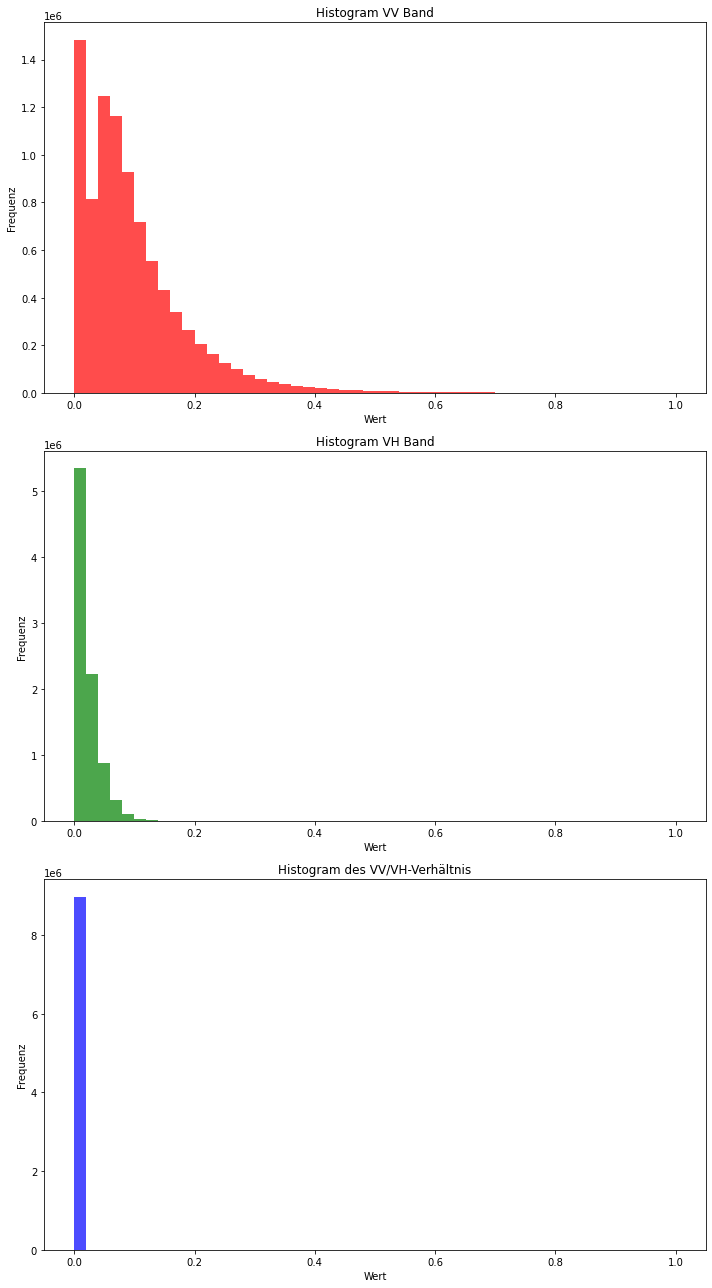

In [86]:
# Erstellen eines Plot
plt.figure(figsize=(10, 18))

# Erstellen des Subplot für das VV Band
plt.subplot(3, 1, 1)
plt.hist(vv_data.flatten(), bins=50, range=(0,1), color='red', alpha=0.7)
plt.title('Histogram VV Band')
plt.xlabel('Wert')
plt.ylabel('Frequenz')

# Erstellen des Subplot für das VH Band
plt.subplot(3, 1, 2)
plt.hist(vh_data.flatten(), bins=50, range=(0,1), color='green', alpha=0.7)
plt.title('Histogram VH Band')
plt.xlabel('Wert')
plt.ylabel('Frequenz')

# Erstellen des Subplot für das VV/VH Band
plt.subplot(3, 1, 3)
plt.hist(ratio_normalized.flatten(), bins=50, range=(0,1), color='blue', alpha=0.7)
plt.title('Histogram des VV/VH-Verhältnis')
plt.xlabel('Wert')
plt.ylabel('Frequenz')

# Anzeigen des Plot
plt.tight_layout()
plt.show()

Durch die Histograme wird deutlich, dass sich die Werte auf bestimmte Wertebereiche konzentrieren. Eine Kontraststreckung erscheint deswegen sinnvoll, um eine bessere visuelle Darstellung zu erreichen. Da die Wertebereiche für jedes Band unterschiedlich stark ausgeprägt sind, wird die Streckung auch jeweils individuell angepasst. In diesem Fall ignorieren wir das unter 2%- und das obere 98%-Perzentil und strecken die übrig gebliebenen Werte mithilfe einer linearen Transformation auf den gesamten Wertebereich von 0 bis 1.

In [80]:
# Kontraststreckung pro Band (R, G, B)
composite_stretched = np.zeros_like(composite)
for i in range(3):
    p2, p98 = np.percentile(composite[:, :, i], (2, 98))
    composite_stretched[:, :, i] = np.clip((composite[:, :, i] - p2) / (p98 - p2), 0, 1)

#### 13. Anzeigen des Bildausschnitts

Jetzt können wir die Sentinel-1 Level-2 Backscatter Szene anzeigen. Das VV Band wird rot dargestellt, VH Grün und VV/VH Blau. Diese Information sollte gleich bei der Interpretation der Ergebnisse beachtet werden. 

Wir stellen zunächst das Bild ohne Kontrastverbesserung dar und danach das mit der Kontrastverbesserung, um auf die Unterschiede nach dem Post-processing aufmerksam zu machen.  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


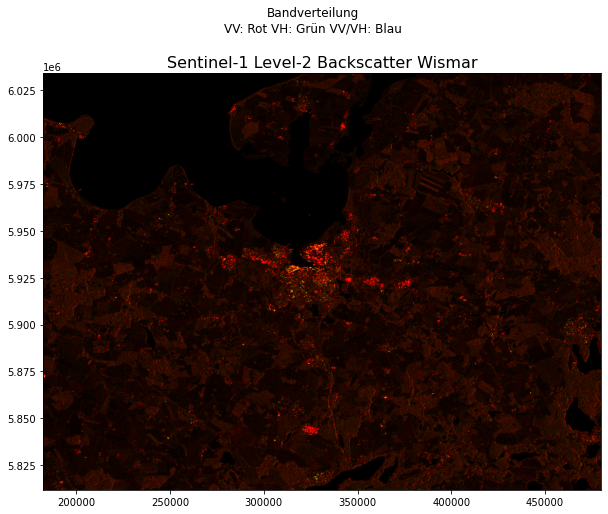

In [82]:
# Festlegen der Plot-Größe
fig, ax = plt.subplots(figsize=(10, 10))

# Anzeigen des Kompositbildes
img = ax.imshow(composite, extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top), vmin=0, vmax=1)

# Festlegen des Titels
ax.set_title(f"Sentinel-1 Level-2 Backscatter {place}", fontsize=16)

# Hinzufügen eines Untertitels
fig.text(0.5, 0.85, "Bandverteilung\nVV: Rot VH: Grün VV/VH: Blau", ha='center', fontsize=12)

# Anzeigen und Schließen des Plots
plt.show()
plt.close()

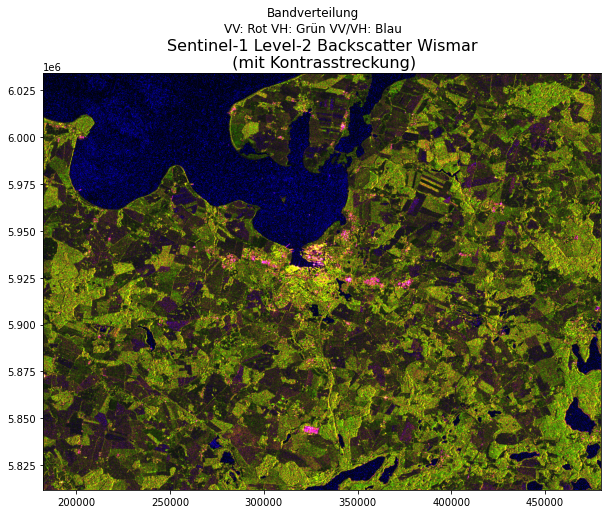

In [83]:
# Festlegen der Plot-Größe
fig, ax = plt.subplots(figsize=(10, 10))

# Anzeigen des kontrastgestreckten Kompositbildes
img = ax.imshow(composite_stretched, extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top))

# Festlegen des Titels
ax.set_title(f"Sentinel-1 Level-2 Backscatter {place}\n(mit Kontraststreckung)", fontsize=16)

# Hinzufügen eines Untertitels
fig.text(0.5, 0.85, "Bandverteilung\nVV: Rot VH: Grün VV/VH: Blau", ha='center', fontsize=12)

# Anzeigen und Schließen des Plots
plt.show()
plt.close()

#### 14. Interpretation des Bildausschnitts

Ohne Kontraststreckung gehen viele Informationen aus den Daten der Sentinel-1 Level-2 Backscatter Szene verloren. Da der Wertebereich des roten Bandes am stärksten ausgeprägt ist, dominiert er das Bild. Lediglich die Informationen aus dem grünen Band sind noch sichtbar. Die Informationen aus dem blauen Band sind nicht mehr vorhanden. Insgesamt sind die Informationen der verschiedenen Bänder ohne eine Kontrastverbesserung visuell nicht vergleichbar. 

Im Bild mit der Kontraststreckung sind die Farben aller Bänder sichtbar. Auch die Mischungen verschiedener Bänder sind erkennbar und können interpretiert werden. Wichtig bei der Interpretation ist die Bedeutung der verschiedenen Farben zu kennen. 

*Blau*

Bedeutung: Niedrige Werte im roten (VV) und grünen (VH) Band, aber ein hohes Verhältnis von VV/VH.

Interpretation: Dies deutet auf Bereiche hin, in denen die Rückstreuung zum Sensor gering ist, wie z.B. Wasserflächen. Wasserflächen haben typischerweise niedrige Rückstreuungswerte in beiden Polarisationen (VV und VH), was zu einer starken Blaufärbung führt.

*Grünlich*

Bedeutung: Hohe Werte im grünen Band (VH), moderate Werte im roten Band (VV) und ein geringes Verhältnis von VV/VH.
   
Interpretation: Dies deutet auf Bereiche mit dichter Vegetation oder Wäldern hin. Vegetation hat typischerweise hohe Rückstreuungswerte in der VH-Polarisation und moderate Werte in der VV-Polarisation, was zu einer grünlichen Färbung führt.

*Magenta/Pink*

Bedeutung: Hohe Werte im roten Band (VV), niedrige Werte im grünen Band (VH) und ein hohes Verhältnis von VV/VH.

Interpretation: Dies könnte auf urbane Gebiete oder künstliche Oberflächen hinweisen, die eine hohe Rückstreuung in der VV-Polarisation und eine niedrige Rückstreuung in der VH-Polarisation aufweisen.


*Bräunlich*

Bedeutung: Moderate Werte im grünen Band (VH), hohe Werte im roten Band (VV) und ein geringes Verhältnis von VV/VH.

Interpretation: Dies könnte auf landwirtschaftliche Flächen oder offene Bodenflächen hinweisen, die moderate Rückstreuungswerte in der VH-Polarisation und hohe Werte in der VV-Polarisation aufweisen.

**Beispielinterpretation**
<ul>
<li>Wasserflächen: Blau dominierte Bereiche</li>
<li>Vegetation: Grünlich dominierte Bereiche</li>
<li>Urbane Gebiete: Magenta/Pink dominierte Bereiche</li>
<li>Landwirtschaftliche Flächen: Bräunlich dominierte Bereiche</li>
</ul>

Wichtig ist bei der Interpretation den Kontext der Szene etwas zu kennen. Die Stadt mit ihren vielen Grünflächen ist an sich eher grünlich und gelb, teilweise Magenta/Pink auf der Abbildung. Letzteres steht im Zusammenhang mit den stark versiegelten Hafenanlagen. Weitere pinke Bereiche sind eine landwirtschaftliche Zuchtanlage im Süden der Stadt sowie eine Solaranlage im Osten, die beide stark versiegelt sind. Die Umgebung Wälder und landwirtschaftliche Flächen dominiert, die sich auch in der Abbildung mit den grünlichen und bräunlichen Farben abwechseln.